In [4]:
from torch.utils.data import DataLoader
from train import Trainer
from models import Generator, Critic
import os
import data.data_preprocessing as data_prep
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import shutil

c:\Users\bolla\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We found the model having some problems when generate really small values, for that reason we scaled the series by a factor of 100 when training the model. Than It's necessary to divide by a factor of 100 the raw model output. 

In [17]:
#create the transformer to scale the series
class ScaleInput:

    def __call__(slef, sample):
        return sample * 100

class MinMaxScaler:

    def __init__(self, range = (0,1)):
        self.min = range[0]
        self.max = range[1]

    def __call__(self, sample):

        cap = torch.max(sample)
        bottom = torch.min(sample)

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (self.max - self.min) + self.min
        
        return X_scaled

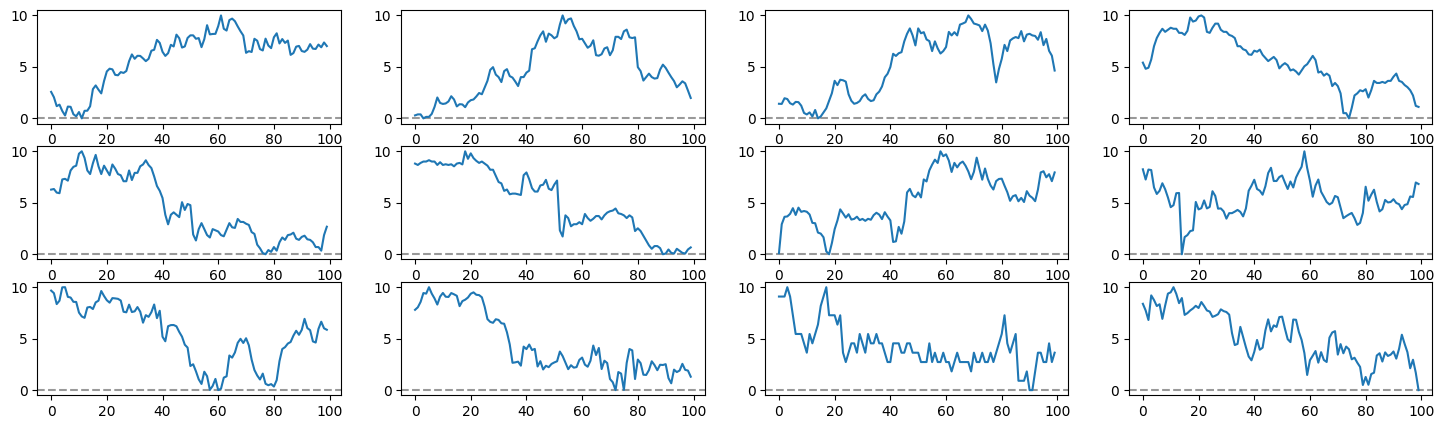

In [44]:
scaler = MinMaxScaler(range = (0,10))
#create the dataloader
dataset = data_prep.WindowsDaset(r'data\dataset_price',transform = scaler)
#plotsome series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(18,5))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

In [20]:
def create_dir(location, name):
    os.mkdir(os.path.join(location, name))
    shutil.copy('models.py', os.path.join(location, name))
    os.mkdir(os.path.join(location, name, 'training_samples'))
    os.mkdir(os.path.join(location, name, 'checkpoints'))
    os.mkdir(os.path.join(location, name, 'training_samples','dynamic_latents'))
    os.mkdir(os.path.join(location, name, 'training_samples','fixed_latents'))
    return os.path.join(location, name)

In [46]:
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = create_dir(BASE_DIR,'000_002')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\bolla\\Desktop\\CUHK_courses\\IASP_elisa\\runs\\000_002'

In [22]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [53]:
import importlib
import models
importlib.reload(models)
from models import Generator, Critic

In [54]:
# Instantiate Generator and Critic + initialize weights
if False:
    from checkpoints import models_test
    state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))
    

    g = models_test.Generator()
    g.load_state_dict(state_dicts['g_state_dict'])
    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)


    c = models_test.Critic()
    c.load_state_dict(state_dicts['d_state_dict'])
    c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)
    
else:

    g = Generator()
    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

    c = Critic()
    c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

log_name = LOG_NAME
# Instantiate Tensorboard writer
tb_logdir = os.path.join('tensorboard', log_name)
writer = SummaryWriter(log_dir=tb_logdir)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, writer=writer, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

Training is about to start...


 28%|██▊       | 11/40 [17:58<47:24, 98.08s/it]  


KeyboardInterrupt: 

In [26]:
# the following function allow to generate a sample to test the model
def generate_sample(model, out_tensor : bool):
    pr = model(torch.rand((1,50)))
    plt.plot(pr.detach().numpy()[0]/100)
    plt.axhline(0)
    
    #plt.ylim(-1,1)
    
    if out_tensor == True:
        return pr.detach().numpy()[0]

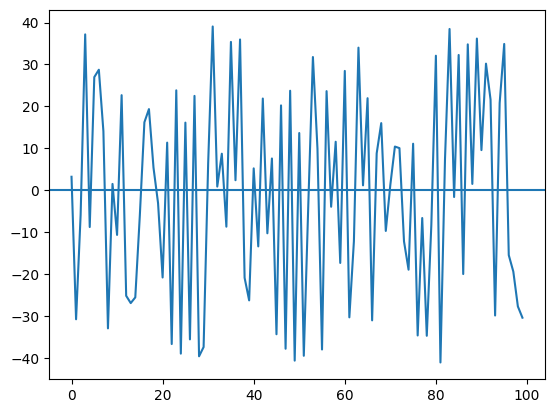

In [41]:
pr_r = generate_sample(g, out_tensor = True)

4.4350314